# Vodafone challenge

In [1]:
# Import useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.simplefilter('ignore')

# Import evaluation libraries
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Import model libraries
from xgboost import XGBClassifier

# Random seed for reproducibility
seed = 202
np.random.seed(seed)

## import, clean and sort the dataset

In [2]:
# Import the train set and test set
train_data = pd.read_csv("nan_final_train.csv", delimiter=",")
test_data = pd.read_csv("nan_final_test.csv", delimiter=",")

# Drop the ID column
train_data = train_data.drop('ID', axis=1)

# Sort the dataset
train_data = train_data.iloc[np.random.permutation(len(train_data))]
train_data = train_data.reset_index(drop=True)

## compute the best features with SelectKBest

In [3]:
# Select the best features for binary and multiclass tasks

array = np.asarray(train_data.dropna())

# X,Y are the splits between features and labels used to evaluate SelectKBest
X = array[:,0:train_data.shape[1]-1]
X = np.asarray(X)
Y = array[:,train_data.shape[1]-1]
Y = np.asarray(Y)

# Evaluate the features with a chi2 test by using SelectKBest
bin_feature_number = 'all'
bin_chi2_test = SelectKBest(score_func=chi2, k=bin_feature_number)
fit = bin_chi2_test.fit(X,Y)
bin_feat = train_data.columns[bin_chi2_test.get_support(indices=True)]

v_feature_number = 'all'
v_chi2_test = SelectKBest(score_func=chi2, k=v_feature_number)
fit = v_chi2_test.fit(X,Y)
v_feat = train_data.columns[v_chi2_test.get_support(indices=True)]

In [4]:
def MinMaxScaler_Column(column):
    return (column - column.min())/(column.max()-column.min())

In [5]:
def features_labels_split(data):   
    features = data[bin_feat]
    labels = data['Product']
    # Data normalization
    data['Region'] = MinMaxScaler_Column(data['Region'])
    data['Province'] = MinMaxScaler_Column(data['Province'])
    data['CustomerAge'] = MinMaxScaler_Column(data['CustomerAge'])
    data['ZipCode'] = MinMaxScaler_Column(data['ZipCode'])
    
    return features, labels

In [6]:
def train_test_validation_split(features, labels, val_samples, test_samples):

    features = np.asarray(features)
    labels =np.asarray(labels)
    
    X_test = features[0:test_samples]
    y_test = labels[0:test_samples]

    X_val = features[test_samples:test_samples + val_samples]
    y_val = labels[test_samples:test_samples + val_samples]

    X_train = features[test_samples + val_samples:]
    y_train = labels[test_samples + val_samples:]

    return X_train, X_test, X_val, y_train, y_test, y_val

## first data creation

In [11]:
# train_feat, train_label are the splits of train_data between features and labels
train_feat, train_label = features_labels_split(train_data.dropna())

train_feat = train_feat.reset_index(drop=True)
train_label = train_label.reset_index(drop=True)

# bin_train_label is the same of train_label but BINARY
bin_train_label = []
 
for i in range(0, len(train_label)):
    if(train_label[i] == 0):
        bin_train_label.append(0)
    else:
        bin_train_label.append(1)
bin_train_label = np.asarray(bin_train_label)


num_val_samples = 0
num_test_samples = 950
# bin_X_train, bin_X_test, bin_X_val, bin_y_train, bin_y_test, bin_y_val are the splits of train_feat and bin_train_label
bin_X_train, bin_X_test, bin_X_val, bin_y_train, bin_y_test, bin_y_val = train_test_validation_split(train_feat, bin_train_label, num_val_samples, num_test_samples)

In [12]:
bin_X_train.shape

(5210, 34)

XGBoostError: b'value 0 for Parameter num_class should be greater equal to 1'

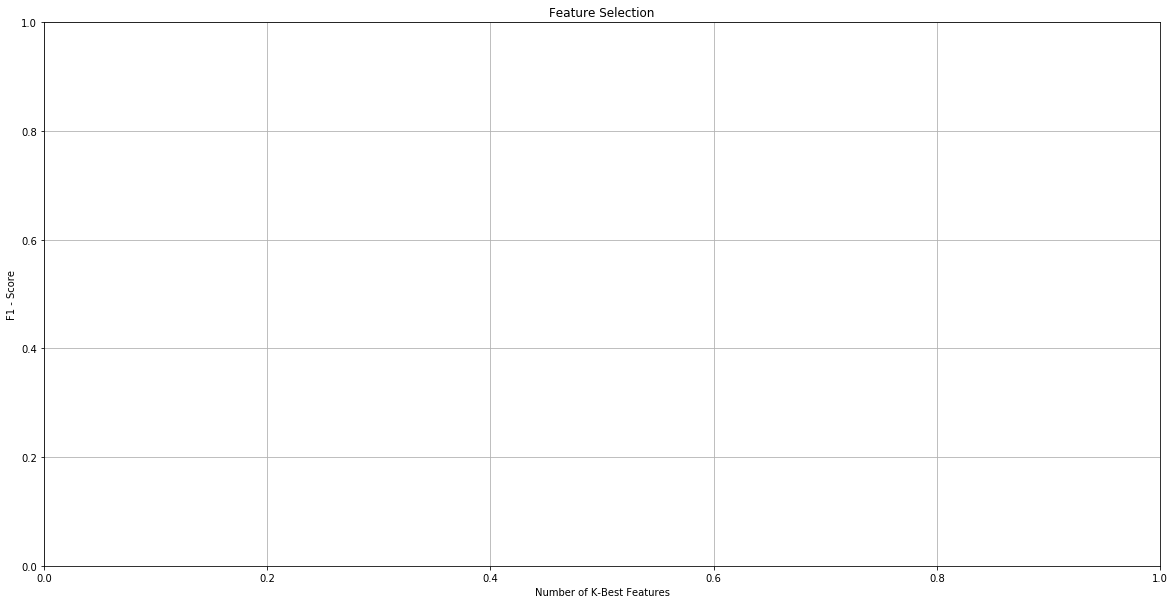

In [14]:
xgb = XGBClassifier(n_jobs=-1, objective='multi:softmax', random_state=seed)

models = []
models.append(('XGB', xgb, 'Cyan'))


feat_range = bin_X_train.shape[1]

n = ['XGB']
n_number = np.arange(2,feat_range,1)
# Transforming the lists into array for plotting
plt.figure(figsize=(20, 10))
plt.title('Feature Selection')
plt.xlabel("Number of K-Best Features")
plt.ylabel("F1 - Score")
plt.grid()

num_feat_arr = []
for name, model, c in models:
    
    scores = [0, 0]
    results = []

    for n in range(2,feat_range):

        selection = SelectKBest(k=n).fit(bin_X_train,bin_y_train)
        X_k = selection.transform(bin_X_train)
        
        score = cross_val_score(estimator = model, X = X_k, y = bin_y_train, cv = 5, scoring='f1')
        f1 = score.mean()
        
        results.append(f1)
        
        std = score.std()
        if scores[0] < f1:
            scores = [f1, n]
  
    plt.plot(n_number, results, 'o-', color=c, label=name)
    
    num_feat_arr.append(scores[1])
    max_avg = np.average(scores)
    
    print("Model: %s, Avg_Score: %.3f, Num_Feat: %d" % (name, scores[0], scores[1]))  


plt.axis([0, feat_range , 0.50, 0.70])
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
plt.show()